In [73]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

twitch_df = pd.read_csv("Twitch_game_data.csv", encoding='latin-1')
igdb_df = pd.read_csv("data.csv", encoding='UTF-8')

twitch_df.columns = twitch_df.columns.str.strip()
igdb_df.columns = igdb_df.columns.str.strip()

print("Twitch Data Columns:", twitch_df.columns)
print("IGDB Data Columns:", igdb_df.columns)

merged_df = pd.merge(twitch_df, igdb_df, on='Game', how='left')

print("Before dropna, columns:", merged_df.columns)
print("Missing values:\n", merged_df.isna().sum())

for col in ['Rank','Avg_viewers', 'Hours_streamed', 'Peak_viewers', 'Streamers']:
    if col + "_x" in merged_df.columns and col + "_y" in merged_df.columns:
        merged_df[col] = merged_df[col + "_x"].fillna(merged_df[col + "_y"])
        merged_df.drop(columns=[col + "_x", col + "_y"], inplace=True)
    elif col + "_x" in merged_df.columns:
        merged_df.rename(columns={col + "_x": col}, inplace=True)
    elif col + "_y" in merged_df.columns:
        merged_df.rename(columns={col + "_y": col}, inplace=True)

if "Rank" not in merged_df.columns:
    raise KeyError("Missing 'Rank' column after merging.")
    
if "Release_Year" in merged_df.columns:
    merged_df["Release_Year"] = pd.to_numeric(merged_df["Release_Year"], errors="coerce")
    merged_df.dropna(subset=["Release_Year"], inplace=True)
    merged_df["Release_Year"] = merged_df["Release_Year"].astype(int)
else:
    raise KeyError("Missing 'Release_Year' in dataset.")

if "Genre" in merged_df.columns:
    merged_df = pd.get_dummies(merged_df, columns=["Genre"], dummy_na=True)
features = ["Avg_viewers", "Hours_streamed", "Peak_viewers", "Streamers"] \
           + [col for col in merged_df.columns if col.startswith("Genre_")]

target = "Rank"
missing_cols = set(features) - set(merged_df.columns)
if missing_cols:
    raise KeyError(f"Missing columns in dataset: {missing_cols}")

X = merged_df[features]
y = merged_df[target]




Twitch Data Columns: Index(['Rank', 'Game', 'Month', 'Year', 'Hours_watched', 'Hours_streamed',
       'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers',
       'Avg_channels', 'Avg_viewer_ratio'],
      dtype='object')
IGDB Data Columns: Index(['Rank', 'Game', 'Month', 'Year', 'Hours_watched', 'Hours_streamed',
       'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers',
       'Avg_channels', 'Avg_viewer_ratio', 'Genre', 'Release_Year',
       'Release_Month', 'New_Game', 'Wrong', 'rank_category'],
      dtype='object')
Before dropna, columns: Index(['Rank_x', 'Game', 'Month_x', 'Year_x', 'Hours_watched_x',
       'Hours_streamed_x', 'Peak_viewers_x', 'Peak_channels_x', 'Streamers_x',
       'Avg_viewers_x', 'Avg_channels_x', 'Avg_viewer_ratio_x', 'Rank_y',
       'Month_y', 'Year_y', 'Hours_watched_y', 'Hours_streamed_y',
       'Peak_viewers_y', 'Peak_channels_y', 'Streamers_y', 'Avg_viewers_y',
       'Avg_channels_y', 'Avg_viewer_ratio_y', 'Genre', 'Release_Year'

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(
    n_estimators=100,       
    max_depth=10,             
    random_state=42,
    n_jobs=-1               
)


rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nRandom forest regression model performance：")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")



Random forest regression model performance：
RMSE: 25.49
R²: 0.7949


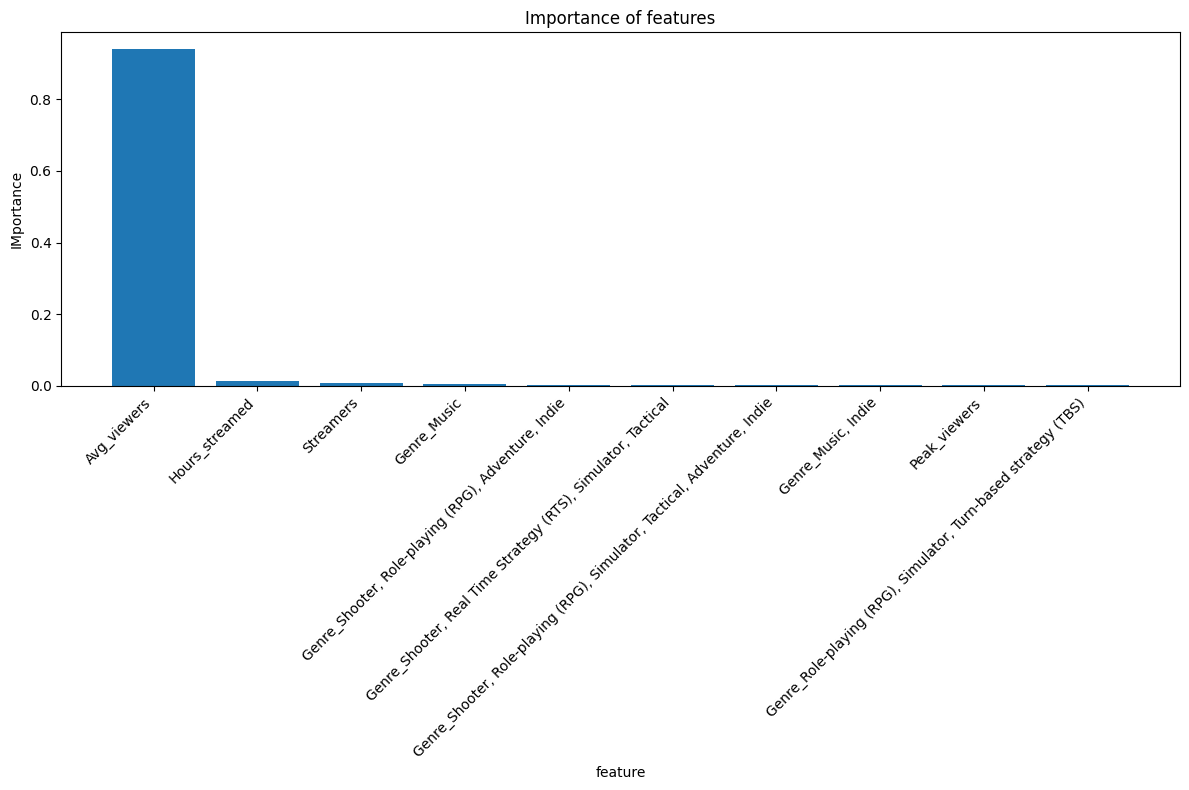

In [75]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Importance of features")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45, ha='right')
plt.xlabel('feature')
plt.ylabel('IMportance')
plt.tight_layout()
plt.show()

In [76]:

def predict_future_rank(year, month):
    X_future = merged_df[(merged_df["Release_Year"] <= year)]

    X_future_games = X_future[["Game"]].copy()

    X_future = X_future.drop(columns=["Rank", "Game"], errors="ignore")

    missing_cols = set(features) - set(X_future.columns)
    for col in missing_cols:
        X_future[col] = 0

    X_future = X_future[features]

    predictions = rf_regressor.predict(X_future)
    X_future["Predicted_Rank"] = predictions

    X_future["Game"] = X_future_games["Game"].values

    X_future = X_future.sort_values("Predicted_Rank").drop_duplicates(subset=["Game"])

    top_10_games = X_future.head(10)
    top_50_games = X_future.head(50)
    top_100_games = X_future.head(100)
    top_200_games = X_future.head(200)

    print(f"\n**Top 10 Games for {year}-{month}**")
    print(top_10_games[["Game", "Predicted_Rank"]])

    print(f"\n**Top 50 Games for {year}-{month}**")
    print(top_50_games[["Game", "Predicted_Rank"]])

    print(f"\n**Top 100 Games for {year}-{month}**")
    print(top_100_games[["Game", "Predicted_Rank"]])

    print(f"\n**Top 200 Games for {year}-{month}**")
    print(top_200_games[["Game", "Predicted_Rank"]])

predict_future_rank(2025, 6)


**Top 10 Games for 2025-6**
                                    Game  Predicted_Rank
0                      League of Legends        1.000000
837703                     Just Chatting        1.000000
317642                          Fortnite        1.178686
585879                              Rust        2.221374
23590   Counter-Strike: Global Offensive        2.383552
837916                Escape from Tarkov        2.420750
392381                 Teamfight Tactics        2.497473
963703                    Counter-Strike        2.522336
135858     PLAYERUNKNOWN'S BATTLEGROUNDS        2.535182
650764                Grand Theft Auto V        2.561703

**Top 50 Games for 2025-6**
                                     Game  Predicted_Rank
0                       League of Legends        1.000000
837703                      Just Chatting        1.000000
317642                           Fortnite        1.178686
585879                               Rust        2.221374
23590    Counter-Strike: 

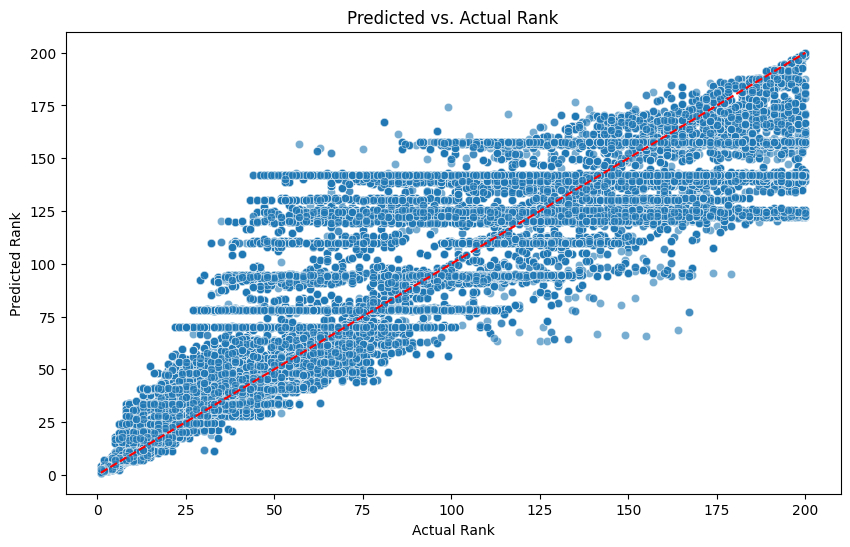

In [77]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Actual Rank")
plt.ylabel("Predicted Rank")
plt.title("Predicted vs. Actual Rank")
plt.show()

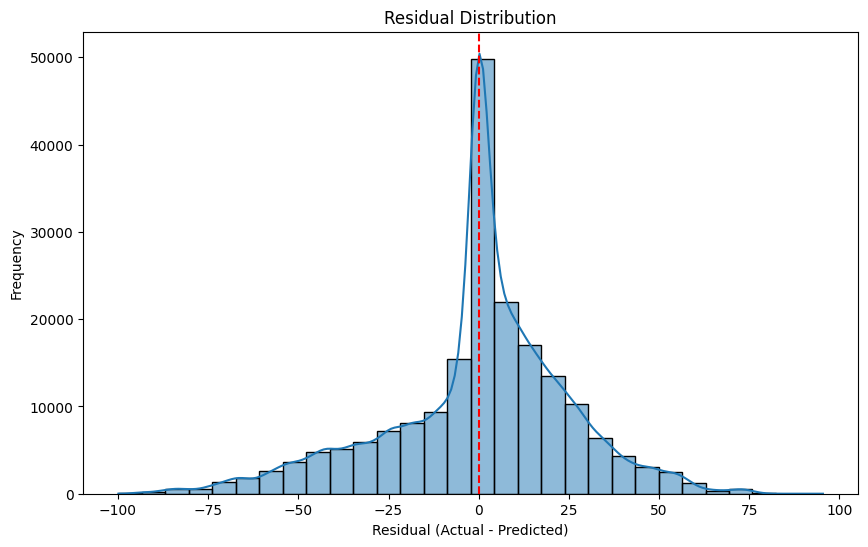

In [78]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color="red", linestyle="dashed")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

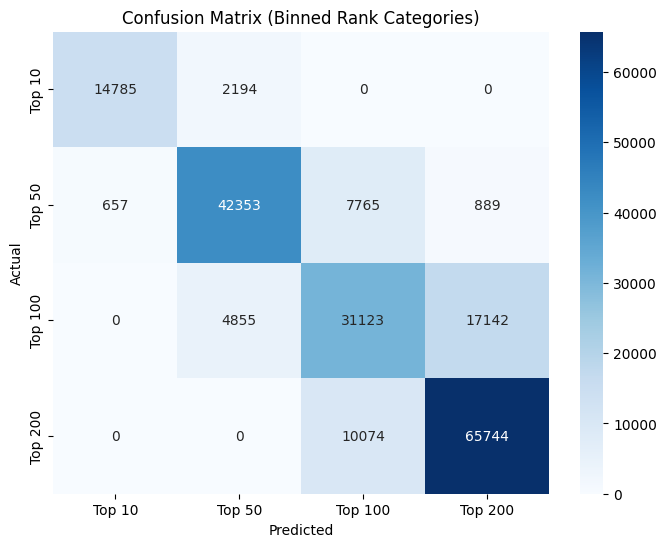

In [79]:
bins = [0, 10, 50, 100, 200, np.inf]
labels = ["Top 10", "Top 50", "Top 100", "Top 200", "Other"]
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

conf_matrix = pd.crosstab(y_test_binned, y_pred_binned, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Binned Rank Categories)")
plt.show()